In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention

In [ ]:
class PatchExtractor(Layer):
    def __init__(self):
        super(PatchExtractor, self).__init__()

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, 10, 10, 1],
            strides=[1, 10, 10, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
!curl -s -o flower.jpeg https://images.unsplash.com/photo-1604085572504-a392ddf0d86a?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=224&q=224 

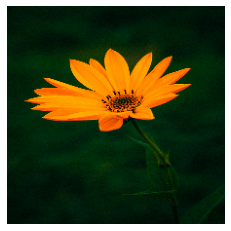

In [ ]:
image = plt.imread('flower.jpeg')
image = tf.image.resize(tf.convert_to_tensor(image), size=(224, 224))
plt.imshow(image.numpy().astype("uint8"))
plt.axis("off");

In [ ]:
tf.shape(image)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([224, 224,   3], dtype=int32)>

In [ ]:
batch = tf.expand_dims(image, axis=0)
patches = PatchExtractor()(batch)
patches.shape

TensorShape([1, 484, 300])

In [ ]:
#196 patches of 16x16

In [ ]:
#n = int(np.sqrt(patches.shape[1]))
#for i, patch in enumerate(patches[0]):
#    ax = plt.subplot(n, n, i + 1)
#    patch_img = tf.reshape(patch, (16, 16, 3))
#    ax.imshow(patch_img.numpy().astype("uint8"))
#    ax.axis("off")

In [ ]:
class PatchEncoder(Layer):
    def __init__(self, num_patches=324, projection_dim=64):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        w_init = tf.random_normal_initializer()
        class_token = w_init(shape=(1, projection_dim), dtype="float32")
        self.class_token = tf.Variable(initial_value=class_token, trainable=True)
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches+1, output_dim=projection_dim)

    def call(self, patch):
        batch = tf.shape(patch)[0]
        # reshape the class token embedins
        class_token = tf.tile(self.class_token, multiples = [batch, 1])
        class_token = tf.reshape(class_token, (batch, 1, self.projection_dim))
        # calculate patches embeddings
        patches_embed = self.projection(patch)
        patches_embed = tf.concat([patches_embed, class_token], 1)
        # calcualte positional embeddings
        positions = tf.range(start=0, limit=self.num_patches+1, delta=1)
        positions_embed = self.position_embedding(positions)
        # add both embeddings
        encoded = patches_embed + positions_embed
        return encoded

In [ ]:
class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        self.dense2 = Dense(out_features)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        y = self.dropout(x)
        return y

In [ ]:
class Block(Layer):
    def __init__(self, projection_dim, num_heads=2, dropout_rate=0.1):
        super(Block, self).__init__()
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.mlp = MLP(projection_dim * 2, projection_dim, dropout_rate)

    def call(self, x):
        # Layer normalization 1.
        x1 = self.norm1(x) # encoded_patches
        # Create a multi-head attention layer.
        attention_output = self.attn(x1, x1)
        # Skip connection 1.
        x2 = Add()([attention_output, x]) #encoded_patches
        # Layer normalization 2.
        x3 = self.norm2(x2)
        # MLP.
        x3 = self.mlp(x3)
        # Skip connection 2.
        y = Add()([x3, x2])
        return y

In [ ]:
class TransformerEncoder(Layer):
    def __init__(self, projection_dim, num_heads=4, num_blocks=4, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.blocks = [Block(projection_dim, num_heads, dropout_rate) for _ in range(num_blocks)]
        self.norm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(0.5)

    def call(self, x):
        # Create a [batch_size, projection_dim] tensor.
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        y = self.dropout(x)
        return y

In [ ]:
def create_VisionTransformer(num_classes, num_patches=324, projection_dim=64, input_shape=(180, 180, 3)):
    inputs = Input(shape=input_shape)
    # Patch extractor
    patches = PatchExtractor()(inputs)
    # Patch encoder
    patches_embed = PatchEncoder(num_patches, projection_dim)(patches)
    # Transformer encoder
    representation = TransformerEncoder(projection_dim)(patches_embed)
    representation = GlobalAveragePooling1D()(representation)
    # MLP to classify outputs
    logits = MLP(projection_dim, num_classes, 0.5)(representation)
    # Create model
    model = Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
model = create_VisionTransformer(2)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 patch_extractor_1 (PatchExt  (None, None, 300)        0         
 ractor)                                                         
                                                                 
 patch_encoder (PatchEncoder  (None, 325, 64)          40128     
 )                                                               
                                                                 
 transformer_encoder (Transf  (None, 325, 64)          332928    
 ormerEncoder)                                                   
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                      

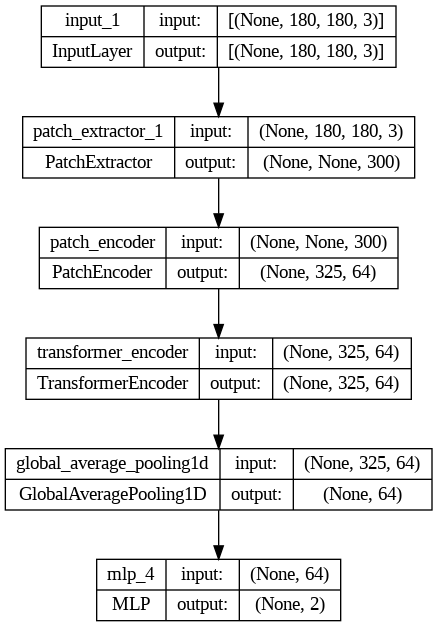

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  77.8M      0  0:00:10  0:00:10 --:--:-- 93.1M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip

replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 1590 images


In [ ]:
image_size = (180, 180)
batch_size = 4

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.95,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 1171 files for training.
Using 22239 files for validation.


In [ ]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
def norm_function(image,label):
    return (image/255.),label

normalized_dataset_train = train_ds.map(norm_function)
normalized_dataset_val = val_ds.map(norm_function)

In [ ]:
import keras

In [ ]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    normalized_dataset_train,
    epochs=epochs,
    validation_data=normalized_dataset_val,
)


Epoch 1/5
293/293 [==============================] - 96s 309ms/step - loss: 7.6499 - accuracy: 0.4902 - val_loss: 7.6685 - val_accuracy: 0.4985
Epoch 2/5
293/293 [==============================] - 89s 306ms/step - loss: 7.3946 - accuracy: 0.5346 - val_loss: 7.6899 - val_accuracy: 0.4985
Epoch 3/5
293/293 [==============================] - 89s 305ms/step - loss: 7.4432 - accuracy: 0.4962 - val_loss: 7.6899 - val_accuracy: 0.5028
Epoch 4/5
293/293 [==============================] - 90s 307ms/step - loss: 7.5958 - accuracy: 0.4944 - val_loss: 7.6899 - val_accuracy: 0.5087
Epoch 5/5
293/293 [==============================] - 89s 305ms/step - loss: 7.6584 - accuracy: 0.4774 - val_loss: 7.6899 - val_accuracy: 0.4985
